# cutting stock problem with Genetic Algorithm
## AmirAli Amini
### 610399102

To speed up the algorithm execution, I used the NumPy library.

In [175]:
import random
import numpy as np
import matplotlib.pyplot as plt

In this algorithm, during each generation of new offspring, 20 members are selected twice in 50 iterations, and from these 20 members, one more fit individual is chosen. Therefore, the population must always be greater than 20. This function is intended to reduce pressure on the population since this problem has local maxima and does not possess a single global maximum. 

For mutation, I used a mutation chance of 0.2 to 0.3 for values less than 60, while for values between 60 and 100, I tested mutation rates from 0.1 to 0.7. 

For the value of 60, a rate of 0.7 yielded the best results, and for 100, I used a rate of 0.5. Given the considerable time the algorithm takes, I decided to keep this rate.

The mutation algorithm operates by swapping a maximum of 20% of the members (ensuring that duplicate values are not generated in a chromosome). 

As a result, it is always guaranteed that there are no duplicate genes in any chromosome. 

To ensure this during the production of new offspring, I also check that the offspring's genome does not contain duplicates from the parents. For crossover, I select two random points and derive the parents from these points to produce offspring.

Regarding population size, it did not significantly impact small values, but for a population size of 28 with 8 pieces and 48 for 20 pieces, I achieved the fastest results.

Initially, I tested with a population size of 60 and observed that all members became similar, and mutations occurred infrequently and slowly. I then tested with a size of 120 to increase exploration and enhance the chances of reaching the maximum points.

The fitness function counts the number of conflicts among the pieces and divides it by the total possible conflicts. This way, I always maintain a fitness value between 0 and 1. I first noticed this approach online, and then I found that it works much better in the code, allowing me to have a consistent value that provides better clarity.

I will elaborate on each case further below.

In [176]:

class geneticAlgorithm:
    def __init__(self,pop_size,maxGeneration=1000,randomness=0.8):
        self.numberOfRolls = 0
        self.rollLengths = 0
        self.requests= []
        self.pop_size = pop_size
        self.randomness=randomness
        self.maxGeneration=maxGeneration

    def inputFile(self , path ):
        file = open(path, 'r')
        lines = file.readlines()
        rollLengths  = int(lines[0].split()[-1])
        requests = list(map(int,lines[3][:-1].split(', ')))
        expectedAnswer =  int(lines[5].split()[-1])
        self.initializer(requests ,rollLengths,expectedAnswer)

    def initializer(self , requests , rollLengths,expectedAnswer):
        self.numberOfRolls = len(requests)
        self.requests = requests
        self.expectedAnswer=expectedAnswer
        self.rollLengths=rollLengths
        self.numberOfRolls=len(requests)
        self.population=[np.array(random.sample(range(self.numberOfRolls),self.numberOfRolls)) for i in range(self.pop_size)]
        self.fitness_arr = [ 0 for i in range(self.pop_size)]
        self.fitness_array_function()

        

    def sort_pop_by_fitness(self):
        n = self.pop_size
        swapped = False
        for i in range(n):
            for j in range(0,n-i-1):
                if self.fitness_arr[j] > self.fitness_arr[j + 1]:
                    swapped = True
                    self.fitness_arr[j], self.fitness_arr[j + 1] = self.fitness_arr[j + 1], self.fitness_arr[j]
                    self.population[j], self.population[j + 1] = self.population[j + 1], self.population[j]
            if not swapped:
                return

    def fitness_function(self,chromosome):
        fitness_value = 0
        temp = 0
        for item in chromosome:
            temp += self.requests[item]
            # print (temp)
            if (temp>self.rollLengths): 
                fitness_value+=1
                temp =self.requests[item]
        if (temp):
            fitness_value+=1


        return fitness_value
        
    def fitness_array_function(self):
        for ind in range(self.pop_size):
            current_fitness = self.fitness_function(self.population[ind])
            self.fitness_arr[ind] = current_fitness
        return self.fitness_arr

    def crossover(self,chromosome_A, chromosome_B):
        n = len(chromosome_A)
        point1 = random.randint(0, n-2)
        point2 = random.randint(point1+1, n-1)
        child1 = [None]*n
        child2 = [None]*n

        child1[point1:point2] = chromosome_A[point1:point2]
        child2[point1:point2] = chromosome_B[point1:point2]


        for i in range(n):
            if child1[i] == None:
                if chromosome_B[i] not in child1:
                    child1[i] = chromosome_B[i]
            if child2[i] == None:
                if chromosome_A[i] not in child2:
                    child2[i] = chromosome_A[i]           


        for i in range(n):
            if child1[i] == None:
                for j in range(n):
                    if j not in child1:
                        child1[i] = j
            if child2[i] == None:
                for j in range(n):
                    if j not in child2: child2[i] = j


        child1_fitness=self.fitness_function(child1)
        child2_fitness=self.fitness_function(child2)
        if child1_fitness<child2_fitness:
            return child1
        return child2


    def mutation(self,chromosome,mutation_prob ):
        
        n = len(chromosome)
        if  random.random()<mutation_prob:
            number_of_mutation = random.randint(0,int(0.2*self.numberOfRolls))
            for _ in range (number_of_mutation):
                index1 = random.randint(0,self.numberOfRolls-1)
                index2 = random.randint(0,self.numberOfRolls-1)
                chromosome[index1],chromosome[index2] = chromosome[index2],chromosome[index1] 
        return chromosome

    def select(self , topPeople=3):
        new_generation=[]
        for i in range(self.pop_size ):
            random_candidates = np.array(random.sample(range(self.pop_size),topPeople))
            min_index1 = min(random_candidates, key=lambda j: self.fitness_arr[j])
            first_parent = (min_index1,self.population[min_index1],self.fitness_arr[min_index1])
            random_candidates = np.array(random.sample(range(self.pop_size),topPeople))
            min_index2 = min(random_candidates, key=lambda j: self.fitness_arr[j])
            second_parent = (min_index2,self.population[min_index2],self.fitness_arr[min_index2])
            new_child = self.crossover(first_parent[1], second_parent[1])
            new_child = self.mutation(new_child,self.randomness)
            new_generation.append(new_child)
        new_generation.sort(key=lambda item:self.fitness_function(item))
        self.sort_pop_by_fitness()
        for index in range(len(new_generation)):
            if self.fitness_function(new_generation[index]) < self.fitness_arr[index] : 
                self.population[index] = new_generation[index]
        self.fitness_arr=self.fitness_array_function()
            
    
    def runner (self):
        print ("requests  ",self.requests)
        print ("rollLengths   ",self.rollLengths)
        print ("numberOfRolls  ",self.numberOfRolls)
        print ("fitness_arr  ",self.fitness_arr)
        print ("expc  ",self.expectedAnswer)
        minimum = 10000000000
        gen = 0
        self.x = []
        self.y=[]
        self.x.append(gen)
        self.y.append(min(self.fitness_arr))
        print (f"in generation {gen } minimum is : { min(self.fitness_arr)}")
        while(min(self.fitness_arr) >self.expectedAnswer) and gen<self.maxGeneration:
            gen +=1
            self.select()
            if (minimum >min(self.fitness_arr) ):
                minimum = min(self.fitness_arr)
                print (f"in generation {gen } minimum is : {minimum}")
            self.x.append(gen)
            self.y.append(minimum)
        self.printBest()


        
    def printBest(self):
        print('the best answer is : ')
        stockToPrint = []
        temp = 0
        fitness_value = 0
        self.sort_pop_by_fitness()
        for item in self.population[0]:
            temp += self.requests[item]
            stockToPrint.append(self.requests[item])
            if (temp>self.rollLengths): 
                fitness_value+=1
                print(fitness_value , ": ", stockToPrint[:-1])
                stockToPrint=[self.requests[item]]
                temp =self.requests[item]

        if (temp):
            fitness_value+=1
            print(fitness_value , ": ", stockToPrint)




    def printPlot(self):
        plt.plot(self.x, self.y)
        plt.xlabel("ith generation")
        plt.ylabel("min fitness")
        plt.show()


For the case of 8, it surprisingly gives a very quick response. This is likely because I set the population size higher than the number of conflict scenarios.

requests   [106, 187, 914, 106, 33, 18, 402, 230, 507, 495, 609, 627, 346, 295, 312, 107, 716, 88, 106, 248, 689, 115, 106, 218, 672, 618, 117, 805, 306, 753, 414, 84, 557, 266, 409, 144, 69, 116, 333, 88, 264, 967, 180, 251, 71, 788, 581, 555, 988, 292, 60, 125, 532, 405, 170, 249, 181, 686, 283, 424, 933, 23, 99, 135, 246, 337, 648, 753, 354, 518, 45, 286, 315, 370, 557, 463, 312, 284, 61, 412, 457, 118, 268, 123, 232, 788, 678, 371, 171, 557, 549, 286, 356, 92, 148, 515, 301, 632, 987, 660, 868, 92, 544, 211, 70, 75, 145, 125, 278, 441, 368, 351, 119, 662, 653, 186, 517, 43, 224, 506, 592, 501, 149, 79, 241, 53, 80, 437, 46, 78, 149, 525, 149, 126, 365, 460, 280, 266, 109, 86]
rollLengths    1000
numberOfRolls   140
fitness_arr   [63, 63, 63, 62, 63, 63, 60, 63, 65, 61, 62, 63, 61, 63, 63, 62, 62, 64, 64, 63]
expc   51
in generation 0 minimum is : 60
in generation 1 minimum is : 60
in generation 3 minimum is : 58
in generation 26 minimum is : 57
in generation 28 minimum is : 56
in g

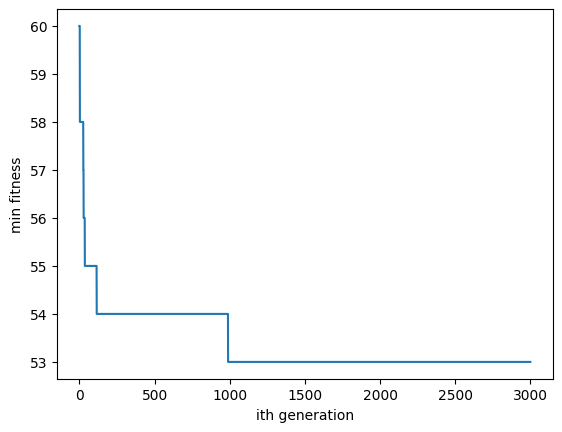

In [177]:
pop = 20
cutting = geneticAlgorithm(pop , maxGeneration = 3000)
cutting.inputFile('input1.stock')
cutting.runner()
cutting.printPlot()




requests   [1520, 2150, 1880, 1520, 2150, 1820, 2150, 2050, 2140, 2140, 1710, 1820, 2150, 1380, 2140, 2150, 1820, 2050, 2100, 1380, 1880, 1880, 1520, 1930, 1710, 2140, 1880, 2050, 1710, 2150, 2000, 1710, 1820, 1560, 2150, 1930, 2000, 1880, 1380, 2050, 1930, 1710, 1820, 1710, 2200, 2050, 1560, 1930, 1930, 2050, 1560, 1380, 1520, 1520, 1520, 2100, 1560, 1520, 2150, 2000, 2000, 2140, 1560, 1880, 2200, 2140, 1930, 2000, 2050, 1520, 1880, 2200, 1520, 1930, 1520, 1710, 1710, 2150, 2100, 2200, 1820, 1820, 2200, 1380, 1880, 1880, 1710, 2140, 1820, 2100, 1380, 1880, 2140, 1820, 1930, 1880, 1880, 1520, 2000, 2050, 2140, 1380, 1380, 1380, 2150, 1380, 2150, 1820, 1820, 2140, 1560, 1710, 1520, 1560, 2140, 2200, 2200, 1880, 2200, 1710, 1930, 2100, 2200, 1820, 1520, 2140, 2100, 1380, 1520, 2140, 2050, 2100, 2200, 2140, 1820, 1820, 1380, 1880, 2140, 2150, 1930, 2100, 2150, 1380, 1710, 1380, 1380, 1520, 2200, 1380, 1560, 1930, 1820, 1930, 1380, 2140, 1520, 2050, 1710, 1880, 1560, 1520, 2150, 1880, 1520

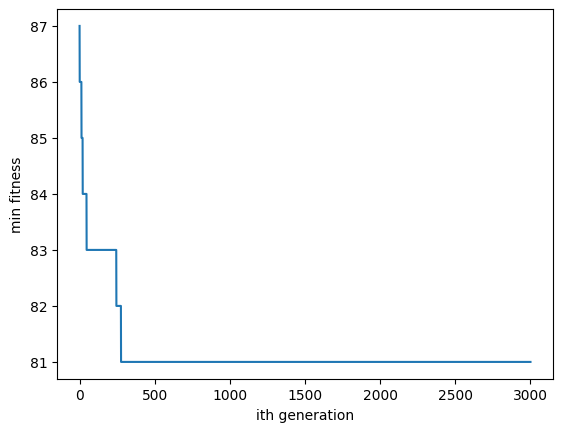

In [178]:
pop = 20
cutting = geneticAlgorithm(pop , maxGeneration = 3000)
cutting.inputFile('input2.stock')
cutting.runner()
cutting.printPlot()

requests   [6, 11, 288, 19, 18, 3, 6, 2, 1, 116, 17, 9, 2, 470, 224, 16, 3, 1, 7, 2, 25, 2, 1, 18, 5, 5, 92, 1, 162, 8, 2, 153, 161, 8, 1, 17, 9, 5, 8, 244, 8, 134, 2, 1, 88, 11, 49, 8, 3, 1, 3, 6, 85, 2, 1, 12, 201, 1, 14, 187, 7, 4, 245, 2, 6, 1, 2, 3, 1, 9, 106, 8, 5, 9, 10, 4, 9, 7, 1, 9, 1, 6, 11, 8, 3, 7, 41, 7, 75, 5, 3, 6, 5, 3, 1, 166, 5, 2, 52, 21, 5, 7, 5, 5, 3, 110, 5, 3, 2, 4, 2, 5, 271, 369, 134, 3, 282, 3, 1, 76, 12, 4, 16, 10, 12, 1, 2, 26, 1, 204, 14, 1, 4, 1, 118, 72, 2, 2, 364, 2, 1, 196, 6, 331, 26, 14, 6, 159, 433, 3, 2, 1, 275, 7, 8, 1, 318, 5, 32, 4, 1, 17, 8, 20, 21, 1, 3, 19, 386, 3, 172, 1, 17, 93, 138, 7, 8, 6, 157, 4, 6, 2, 7, 111, 34, 7, 159, 359, 6, 264, 131, 9, 5, 3, 36, 1, 6, 18, 8, 7, 116, 11, 5, 154, 1, 5, 120, 17, 16, 152, 2, 21, 5, 14, 7, 7, 174, 134, 24, 17, 3, 3, 4, 6, 6, 225, 10, 15, 7, 86, 2, 13, 5, 224, 15, 6, 1, 9, 2, 9, 3, 264, 152, 4, 14, 260, 124, 214, 17, 12, 10, 10, 3, 2, 4, 97, 313, 4, 1, 5, 16, 237, 5, 2, 9, 9, 10, 12, 1, 17, 311, 2, 9, 

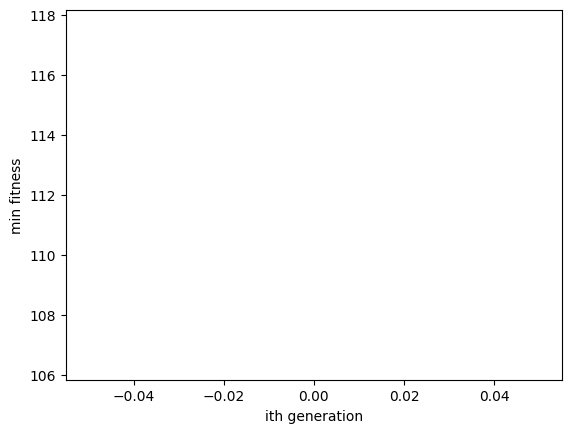

In [179]:
pop = 20
cutting = geneticAlgorithm(pop , maxGeneration = 3000)
cutting.inputFile('input3.stock')
cutting.runner()
cutting.printPlot()

requests   [22, 7, 5, 3, 28, 2, 14, 5, 32, 29, 74, 24, 67, 3, 35, 1, 6, 66, 30, 70, 65, 1, 12, 47, 33, 36, 99, 54, 4, 10, 18, 11, 5, 23, 48, 30, 44, 5, 51, 13, 13, 13, 2, 11, 60, 22, 5, 13, 10, 4, 4, 51, 50, 6, 61, 28, 15, 3, 68, 3, 69, 57, 62, 6, 9, 9, 3, 78, 22, 2, 6, 13, 20, 71, 15, 10, 12, 46, 27, 59, 87, 10, 27, 54, 61, 23, 27, 5, 8, 7, 3, 11, 36, 9, 20, 4, 66, 2, 16, 3, 34, 6, 3, 37, 36, 1, 15, 6, 1, 24, 29, 18, 5, 2, 46, 2, 46, 9, 73, 31, 33, 17, 29, 9, 51, 21, 43, 2, 18, 18, 5, 59, 91, 10, 8, 33, 14, 54, 19, 7, 46, 18, 32, 45, 17, 13, 37, 15, 6, 79, 58, 50, 53, 27, 67, 10, 25, 2, 4, 23, 73, 26, 7, 1, 43, 4, 34, 22, 52, 39, 21, 47, 11, 16, 4, 7, 58, 22, 6, 20, 5, 33, 63, 38, 6, 5, 9, 45, 1, 84, 5, 59, 4, 15, 34, 3, 20, 19, 65, 73, 8, 9, 3, 8, 15, 12, 26, 14, 7, 39, 11, 20, 12, 47, 2, 32, 2, 16, 37, 32, 8, 10, 5, 63, 35, 34, 8, 20, 9, 2, 34, 56, 26, 21, 44, 33, 14, 3, 12, 18, 22, 20, 8, 17, 55, 22, 13, 7, 18, 38, 5, 8, 44, 47, 7, 7, 15, 9, 10, 5, 4, 1, 20, 25, 27, 10, 8, 5, 1, 5,

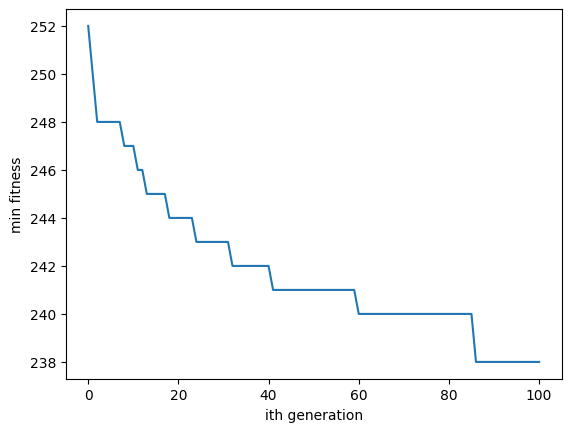

In [183]:
pop = 10
cutting = geneticAlgorithm(pop , maxGeneration = 1000)
cutting.inputFile('input4.stock')
cutting.runner()
cutting.printPlot()